# Calculation of the Feasible Joint Stiffness

A framework for computing the joint stiffness using inverse methods that account
for the musculoskeletal redundancy effects is presented. The process is
separated into five steps:

1. Perform inverse kinematics (IK) and static optimization (SO) using OpenSim to
generate the required data for the next steps

2. Extract the symbolic representation of the muscle moment arm from the OpenSim
model, where higher order derivatives are required for the calculation of the
stiffness

3. Calculate the feasible muscle forces that satisfy both the action and the
physiological constraints of the muscles

4. Calculate the feasible joint stiffness

In [1]:
# notebook general configuration
%load_ext autoreload
%autoreload 2

import os
import pickle
import numpy as np
import sympy as sp
from IPython.display import display
sp.interactive.printing.init_printing()
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 6.0)
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Subject Data

Please provide the following information for the subject under study:

- **.osim** the scaled OpenSim model (after scaling the model using a static
    pose)

- **.trc** the marker trajectories of the movement (based on OpenSim file
    requirements)

- **.mot** the ground reaction forces (based on the OpenSim file format)

- **.xml** describing how to apply the ground reaction forces (based on OpenSim
  force requirements)

- **.xml** file with the reserve actuator for the SO (based on OpenSim requirements)

- **heel strike** and **toe off** events (used for annotation of the results,
  and are not so important)


The following calculations are performed for the *Gait10dof18musc* dataset. 

In [2]:
# time events of toe off and heel strike
heel_strike_right = [0.65, 1.85]
toe_off_right = [0.15, 1.4]
heel_strike_left = [0.0, 1.25]
toe_off_left = [0.8, 2]

# required files and directories
subject_dir = os.getcwd() + '/../dataset/Gait10dof18musc/'
model_file = subject_dir + 'subject01.osim'
trc_file = subject_dir + 'subject01_walk.trc'
grf_file = subject_dir + 'subject01_walk_grf.mot'
grf_xml_file = subject_dir + 'subject01_walk_grf.xml'
reserve_actuators_file = subject_dir + 'reserve_actuators.xml'
results_dir = os.getcwd() + '/notebook_results/'
figures_dir = os.getcwd() + '/results/'

if not (os.path.isfile(model_file) and
        os.path.isfile(trc_file) and
        os.path.isfile(grf_file) and
        os.path.isfile(grf_xml_file) and
        os.path.isfile(reserve_actuators_file)):
    raise RuntimeError('required files do not exist')
    
if not (os.path.isdir(results_dir) and 
        os.path.isdir(figures_dir)):
    raise RuntimeError('required folders do not exist')

## Step 1: Perform Required OpenSim Analyses

In order to perform the feasible muscle force calculations, the kinematics and
kinetics that satisfy the experimental measured motion and ground reaction
forces must be calculated. The following functions make use of the OpenSim IK
and SO analyses.

/usr/lib/python2.7/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


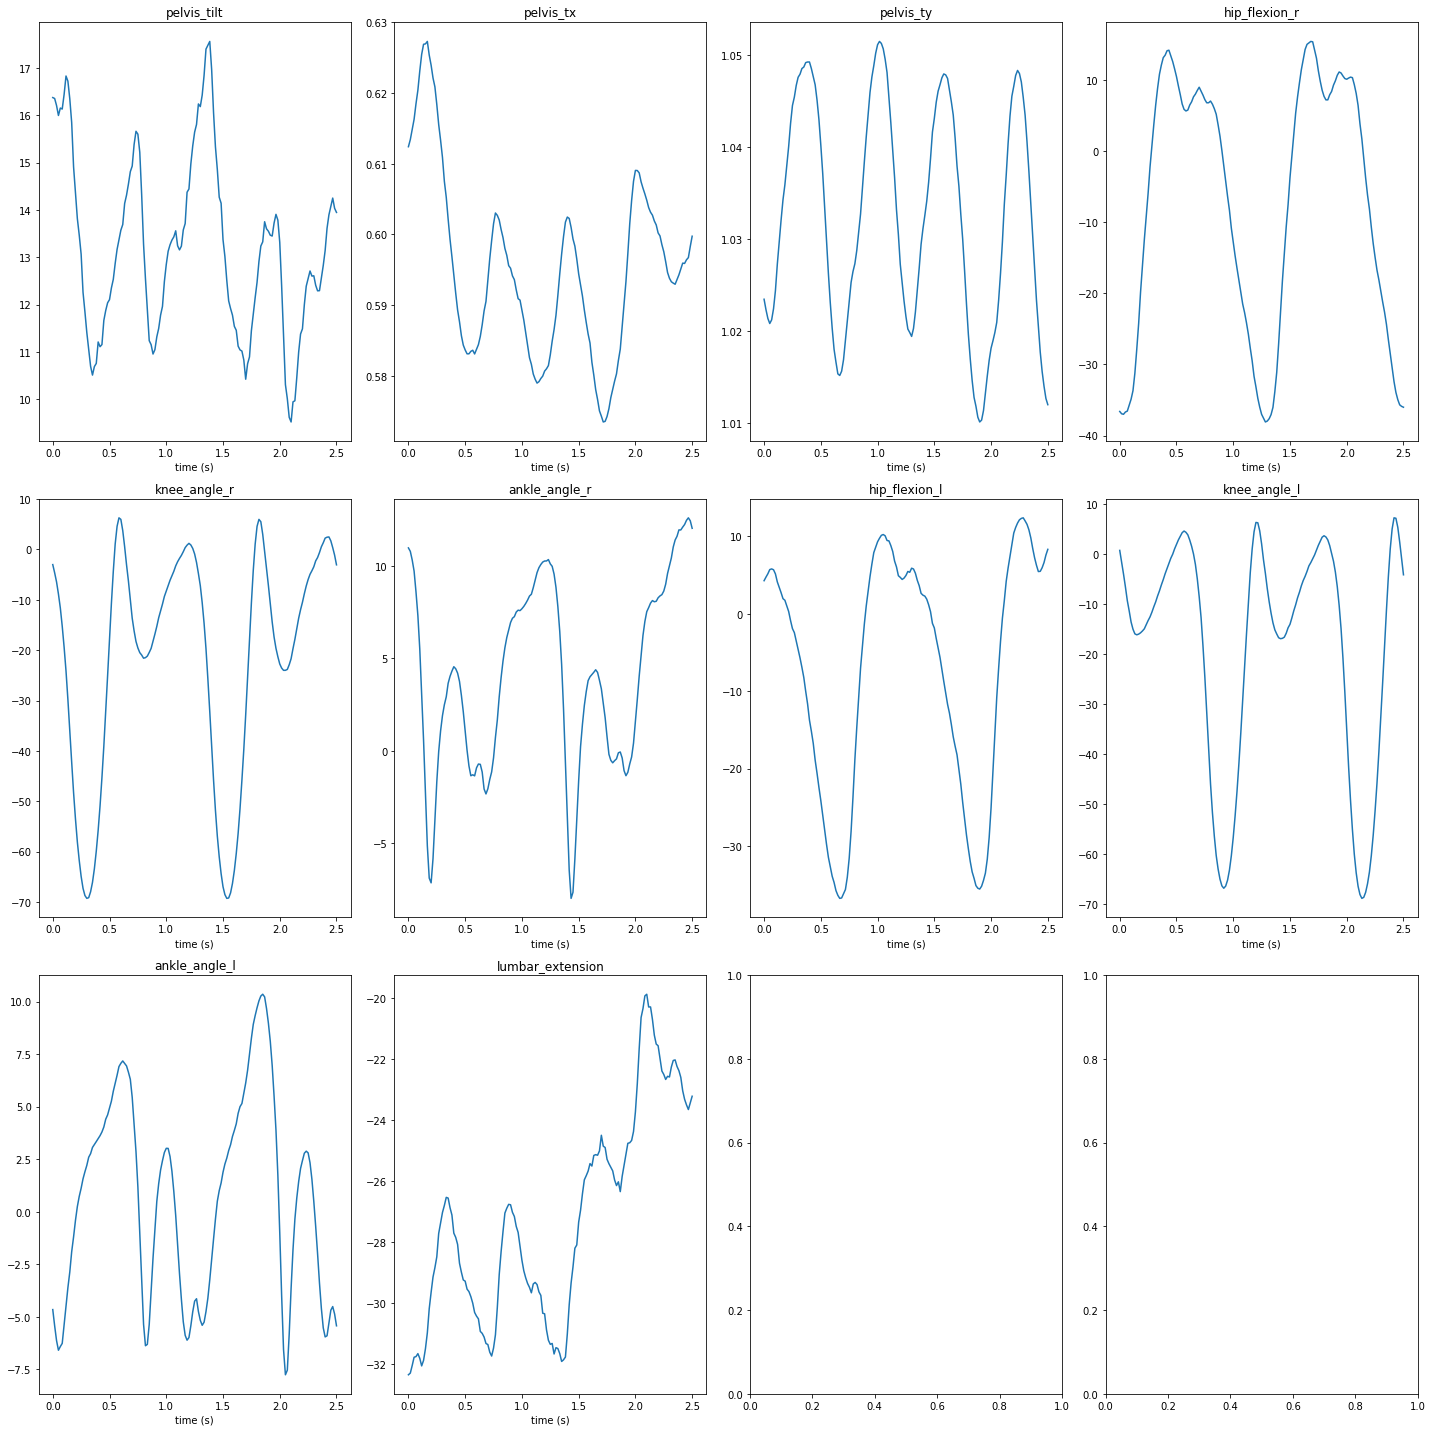

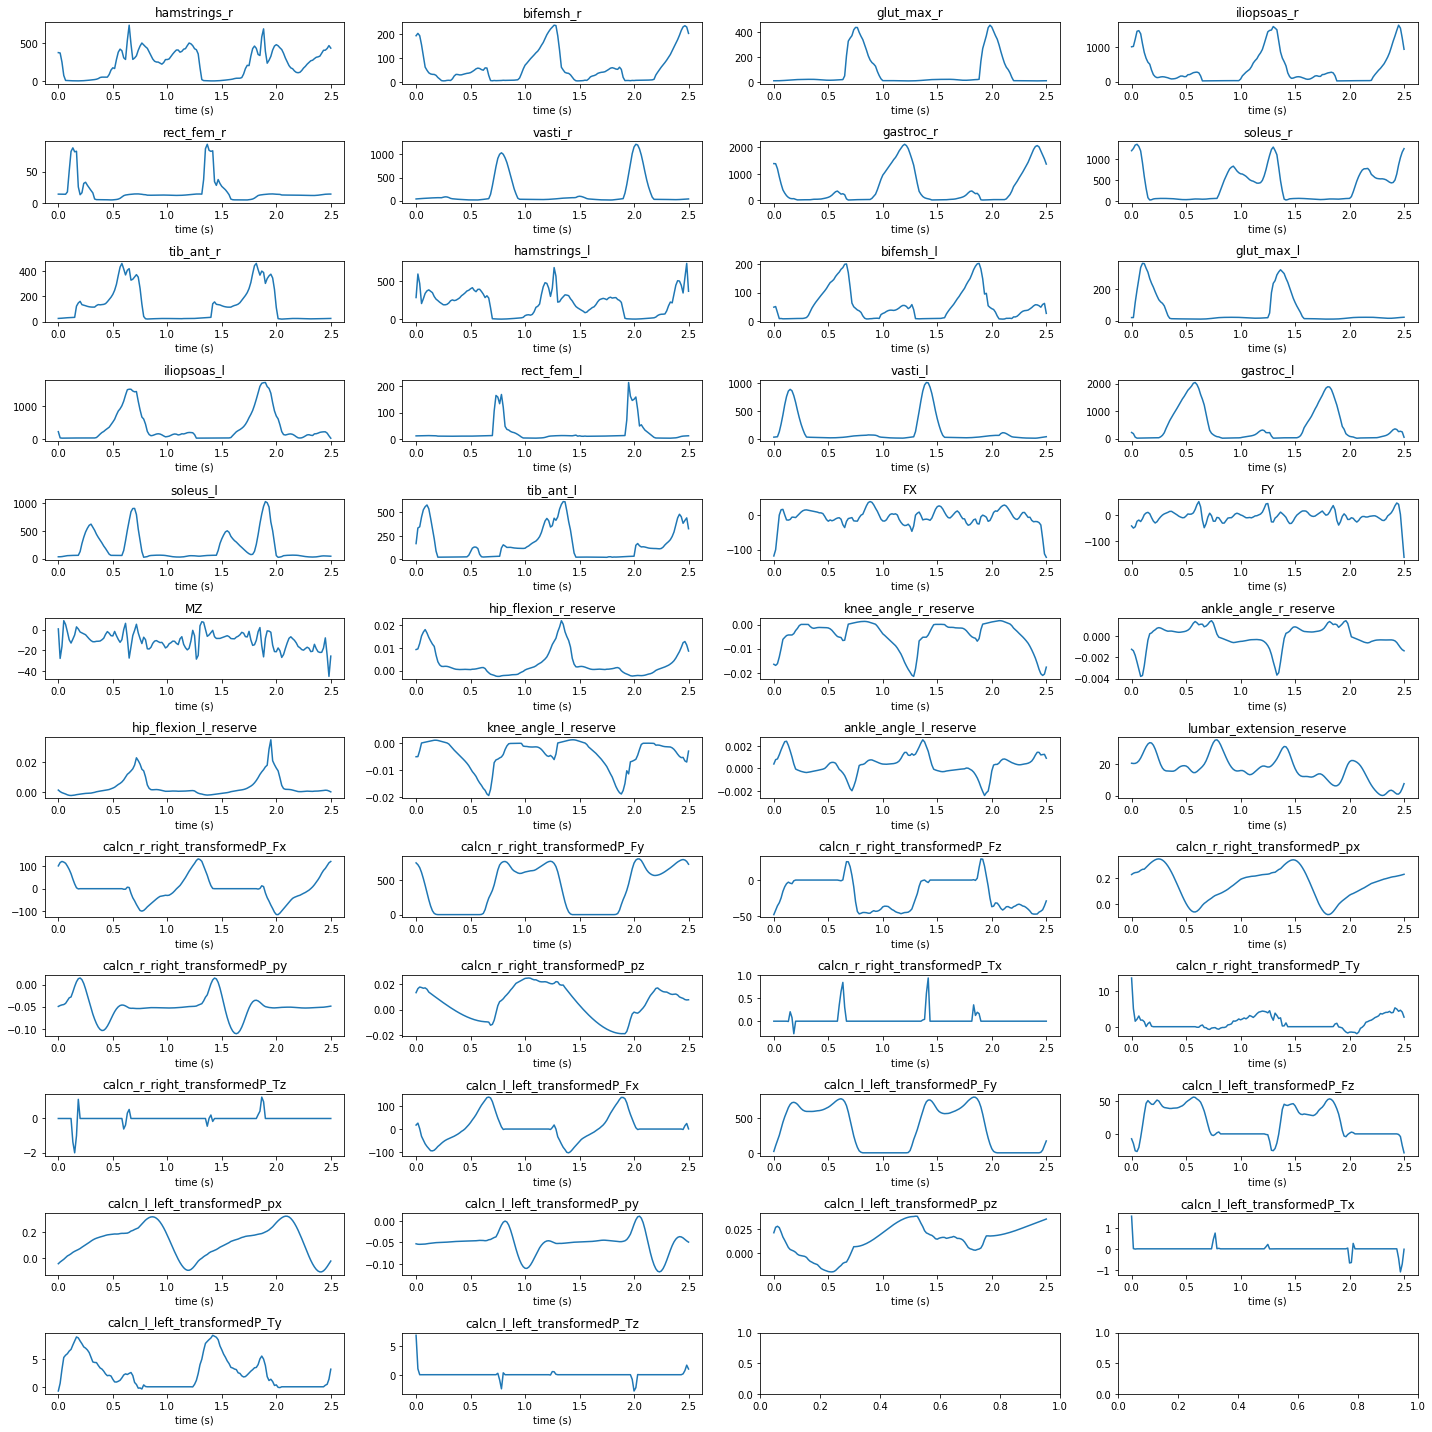

In [3]:
from opensim_utils import perform_ik, perform_so, plot_sto

# perform OpenSim inverse kinematics
ik_file = perform_ik(model_file, trc_file, results_dir)
plot_sto(ik_file, 4, save=True)

# perform OpenSim static optimization
(so_force_file, so_activation_file) = perform_so(model_file, ik_file, grf_file, 
                                                 grf_xml_file, reserve_actuators_file, 
                                                 results_dir)
plot_sto(so_force_file, 4, save=False)

# store file names so that they can be loaded without running this section
pickle.dump((ik_file, so_force_file), file(results_dir + 'opensim_files.dat', 'w'))

In [4]:
# get file names from step 1
(ik_file, so_force_file) = pickle.load(file(results_dir + 'opensim_files.dat', 'r'))

## Step 2: Extract Symbolic Moment Arm

Recall that in the definition of joint stiffness the muscle moment arm must be
differentiated with respect to the generalized coordinates. Unfortunately,
OpenSim lacks the analytical means for evaluating higher order derivatives, as
it computes the muscle moment arm numerically from the input joint
configuration. In order to derive a symbolic representation, multivariate
polynomial fitting was performed on samples of the muscle moment arm at
different configurations. To reduce the complexity and improve the robustness of
the fit, we determined the coordinates affecting each element in the moment arm
matrix, by identifying the DoFs spanned by each muscle.

In [ ]:
# since this section of code may be called independently after step 1 ensure
# that cells 2, 5 and 9 are evaluated
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([2, 5, 9])")

In [6]:
from analytic_moment_arm import calculate_spanning_muscle_coordinates,\
    calculate_moment_arm_symbolically 

# calculate the coordinates that are spanned by each muscle (improves
# robustness)
calculate_spanning_muscle_coordinates(model_file, results_dir)

# calculate the symbolic representation of the muscle moment arm matrix
calculate_moment_arm_symbolically(model_file, results_dir)

  0%|          | 0/18 [00:00<?, ?it/s]

Calculating...


/usr/lib/python2.7/site-packages/multipolyfit/core.py:66: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  beta = linalg.lstsq(A, y)[0]
100%|██████████| 18/18 [00:01<00:00, 15.94it/s]


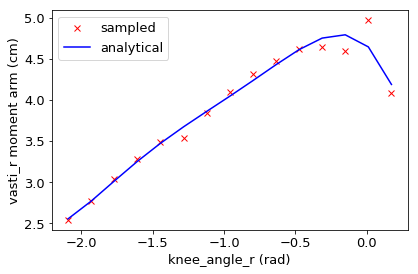

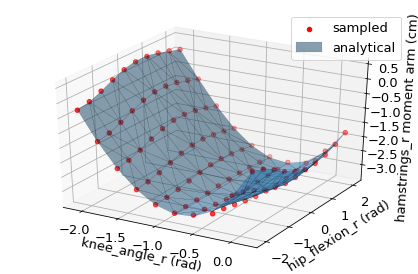

In [7]:
from analytic_moment_arm import visualize_moment_arm

# get files from previous step (to avoid recalculation)
R = pickle.load(file(results_dir + 'R.dat', 'r'))
sampling_dict = pickle.load(file(results_dir + 'sampling_dict.dat', 'r'))
model_coordinates = pickle.load(file(results_dir + 'model_coordinates.dat', 'r'))
model_muscles = pickle.load(file(results_dir + 'model_muscles.dat', 'r'))

# visualize 2D moment arm R(q1)
muscle = 'vasti_r' 
coordinates = sampling_dict[muscle]['coordinates']
visualize_moment_arm(coordinates[0], muscle, coordinates[0], sampling_dict,
                     model_coordinates, model_muscles, R, figures_dir)

# visualize 3D moment arm R(q1, q2)
muscle = 'hamstrings_r'
coordinates = sampling_dict[muscle]['coordinates']
visualize_moment_arm(coordinates[0], muscle, coordinates, sampling_dict,
                     model_coordinates, model_muscles, R, figures_dir)

## Step 3: Calculate the Feasible Muscle Forces

The feasible muscle forces are calculated below. Initially, the moment arm and
maximum muscle force quantities are computed for each instance of the
movement. Then the following inequality is formed assuming a linear muscle model

\begin{equation}\label{equ:linear-muscle-null-space-inequality}
  \begin{gathered}
    f_m = f_{max} \circ a_m = f_m^{\parallel} +
    N_{R} f_{m0},\; 0 \preceq a_m \preceq 1
    \rightarrow \\
    \begin{bmatrix}
      - N_{R} \\
      \hdashline
      N_{R}
    \end{bmatrix}
    f_{m0} \preceq
    \begin{bmatrix}
      f_m^{\parallel} \\
      \hdashline
      f_{max} - f_m^{\parallel}
    \end{bmatrix} \\
    Z f_{m0} \preceq \beta
  \end{gathered}
\end{equation}

where $a_m \in \Re^{m}$ represents a vector of muscle activations, $f_{max} \in
\Re^{m}$ a vector specifying the maximum muscle forces, $\circ$ the Hadamard
(elementwise) product, $f_m^{\parallel}$ the particular muscle force solution
that satisfies the action, $N_{R}$ the moment arm null space and $f_{m0}$ the
null space forces.

The next step is to sample the inequality $Z f_{m0} \leq \beta$. This is the
bottleneck of the analysis. The *convex_bounded_vertex_enumeration* uses the
lsr method, which is a vertex enumeration algorithm for finding the vertices
of a polytope in $O(v m^3)$.

In [ ]:
# since this section of code may be called independently after step 1 ensure
# that cells 2, 5 and 9 are evaluated
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([2, 5, 9])")

In [10]:
from feasible_muscle_forces import calculate_feasible_muscle_forces
    
# calculate the feasible muscle forces that satisfy the motion and physiological
# muscle constraints
calculate_feasible_muscle_forces(model_file, ik_file, so_force_file, results_dir)

  0%|          | 0/151 [00:00<?, ?it/s]

Calculating null space ...


100%|██████████| 151/151 [43:43<00:00, 17.38s/it]


## Step 4: Calculate the Feasible Joint Stiffness

In the following section, we will introduce a method for calculating the
feasible muscle forces that satisfy the motion and the physiological muscle
constraints. As the muscles are the main actors of the system, it is important
to examine the effect of muscle redundancy on the calculation of limbs'
stiffness.

The muscle stiffness is defined as

\begin{equation}\label{equ:muscle-stiffness}
  K_m = \frac{\partial f_m}{\partial l_{m}},\;  K_m \in \Re^{m \times m}
\end{equation}

where $f_m \in \Re^{m}$ represents the muscle forces, $l_{m} \in \Re^{m}$ the
musculotendon lengths and $m$ the number of muscles. The joint stiffness is
defined as

\begin{equation}\label{equ:joint-stiffness}
  K_j = \frac{\partial \tau}{\partial q},\; K_j \in \Re^{n \times n}
\end{equation}

where $\tau \in \Re^{n}$, $q \in \Re^{n}$ are the generalized forces and
coordinates, respectively and $n$ the DoFs of the system. Finally, the task
stiffness is defined as

\begin{equation}\label{equ:task-stiffness}
  K_t = \frac{\partial f_t}{\partial x_t},\; K_t \in \Re^{d \times d}
\end{equation}

where $f_t \in \Re^{d}$ denotes the forces, $x_t \in \Re^{d}$ the positions and
$d$ the DoFs of the task.

The derivation starts with a model for computing the muscle stiffness matrix
$K_m$. The two most adopted approaches are to either use the force-length
characteristics of the muscle model or to approximate it using the definition of
the short range stiffness, where the latter is shown to explain most of the
variance in the experimental measurements. The short range stiffness is
proportional to the force developed by the muscle ($f_m$)

\begin{equation}\label{equ:short-range-stiffness}
  k_{s} = \gamma \frac{f_m}{l_m^o}
\end{equation}

where $\gamma = 23.4$ is an experimentally determined constant and $l_m^o$ the
optimal muscle length. This definition will be used to populate the diagonal
elements of the muscle stiffness matrix, whereas inter-muscle coupling
(non-diagonal elements) will be assumed zero since it is difficult to measure
and model in practice.

The joint stiffness is related to the muscle stiffness through the following
relationship

\begin{equation}\label{equ:joint-muscle-stiffness}
    K_j = -\frac{\partial R^T}{\partial q} \bullet_2 f_m - R^T K_m R
\end{equation}

where the first term captures the varying effect of the muscle moment arm ($R
\in \Re^{m \times n}$), while the second term maps the muscle space stiffness to
joint space. The notation $\bullet_2$ denotes a product of a rank-3 tensor
($\frac{\partial R^T}{\partial q} \in \Re^{n \times m \times n}$, a 3D matrix)
and a rank-1 tensor ($f_m \in \Re^{m}$, a vector), where the index $2$ specifies
that the tensor dimensional reduction (by summation) is performed across the
second dimension, resulting in a reduced rank-2 tensor of dimensions $n \times
n$.

In a similar manner, the task stiffness is related to the muscle stiffness
through the following relationship

\begin{equation}\label{equ:task-muscle-stiffness}
  K_t  = -J_t^{+T} \left(\frac{\partial J_t^T}{\partial q} \bullet_2
    f_t + \frac{\partial R^T}{\partial q} \bullet_2 f_m + R^T
    K_m R\right) J_t^{+}
\end{equation}
  
where the task Jacobian matrix ($J_t \in \Re^{d \times n}$) describes the
mapping from joint to task space ($\Re^{n} \rightarrow \Re^{d}$), $+$ stands for
the Moore-Penrose pseudoinverse and $+T$ the transposed pseudoinverse operator.

Algorithm for calculating the feasible joint stiffness:

**Step 1:** Calculate the feasible muscle forces $f_m^{\oplus}$ that satisfy the
task and the physiological muscle constraints


**Step 2:** Calculate the muscle stiffness matrix $K_m$ using the short range
stiffness model


\begin{equation*}\label{equ:short-range-stiffness-2}
  k_s = \gamma \frac{f_m}{l_m^o},\; \gamma = 23.4
\end{equation*}


**Step 3:** Calculate the joint stiffness $K_j$

\begin{equation*}
    K_j = -\frac{\partial R^T}{\partial q} \bullet_2 f_m - R^T K_m R 
\end{equation*}

In [ ]:
# since this section of code may be called independently after step 3 ensure
# that cells 2, 5 and 9 are evaluated
from IPython.display import Javascript
Javascript("Jupyter.notebook.execute_cells([2, 5, 9])")

In [11]:
from feasible_joint_stiffness import calculate_feasible_joint_stiffness

# calculate feasible joint stiffness
calculate_feasible_joint_stiffness(model_file, ik_file, results_dir)

Initialization ...


  0%|          | 0/151 [00:00<?, ?it/s]

Calculating feasible joint stiffness ...


100%|██████████| 151/151 [06:47<00:00,  2.70s/it]


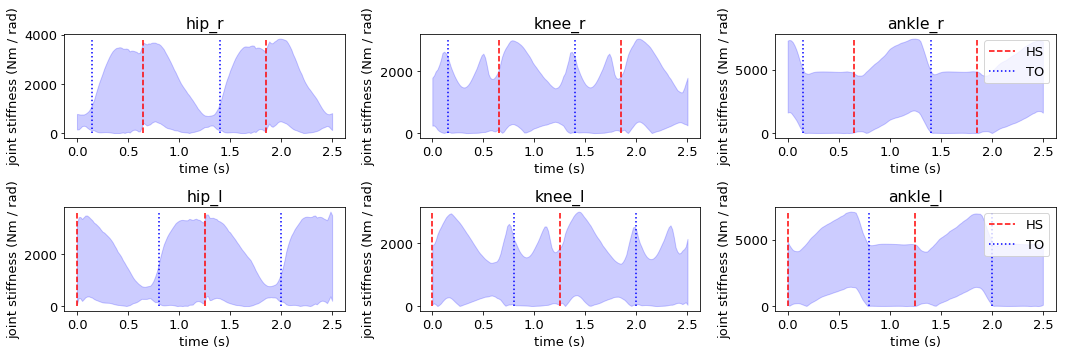

In [12]:
from feasible_joint_stiffness import visualize_feasible_joint_stiffness

# visualize feasible joint stiffness
visualize_feasible_joint_stiffness(results_dir, figures_dir)

This figure depicts the feasible joint stiffness of the hip, knee and ankle
joints during walking with the heel strike and toe-off events annotated
accordingly. These results confirm experimental measurements and furthermore
present similarities in the outline of the minimum stiffness predicted by our
method. Notably, the hip stiffness range is gradually decreasing between heel
strike and toe-off, because the flexor muscles are preparing for the swing phase
and the capacity to increase the joint stiffness reaches its lowest value before
the toe-off event. A similar pattern is observed at the knee joint, which
undergoes a flexion and a subsequent extension during the swing phase. We
observe that the capacity of the muscles to modulate the ankle stiffness is not
decreased and the range is gradually shifted upwards in the region between the
heel strike and toe-off events. The increase in the minimum possible values of
the ankle stiffness is attributed to the counterbalance of the ground reaction
forces by the ankle plantar flexion muscles. As muscle effort is spent by these
muscles, one would expect a lower maximum bound, which is not the case
here. This could be contributed to the fact that the musculoskeletal system is
asymmetric, i.e., the plantar flexion muscles can induce larger magnitudes of
moment at the ankle joint in comparison to the dorsiflexion muscles. We can
conclude that the contribution of the ground reaction forces results in an
increase of the ankle stiffness.